In [1]:
## This Cell is related to date preprocessing and is completely copied from original kipf's github code!

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import torch,torch.nn,torch.sparse,torch.nn.functional,torch.distributions
from sklearn.metrics import roc_auc_score,average_precision_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
np.set_printoptions(threshold=np.inf)


from google.colab import drive
drive.mount('/content/drive')


W_gene      =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/gene.txt", delim_whitespace=True).to_numpy()
W_methy     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/methy.txt", delim_whitespace=True).to_numpy()
W_mirna     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/mirna.txt", delim_whitespace=True).to_numpy()
W_fused     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/W_fused.txt", delim_whitespace=True).to_numpy()

gene      =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Gene_Expression.txt", delim_whitespace=True).to_numpy().transpose()
methy     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Methy_Expression.txt", delim_whitespace=True).to_numpy().transpose()
mirna     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Mirna_Expression.txt", delim_whitespace=True).to_numpy().transpose()
truelabel =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Survival.txt", delim_whitespace=True).to_numpy()



print(gene.shape)
print(methy.shape)
print(mirna.shape)

def get_nomralized_laplacian(a):
    no = a.shape[0]
    a[range(no),range(no)]=1
    b = np.diag(np.power(1.0 / a.sum(axis=1), 0.5))
    return (b @ a @ b)










Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


(215, 12042)
(215, 1305)
(215, 534)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


In [0]:
#Model definition Cell





class Model(torch.nn.Module):

    def __init__(self,optimizer_type,A_tilda_gene,A_tilda_methy,A_tilda_mirna,**kwargs):
        super(Model, self).__init__(**kwargs)
        
        
        
            

        self.W0 = torch.nn.Linear(215,40)
        self.W1 = torch.nn.Linear(40,215)
       
        self.attn_gene = torch.nn.Linear(215,1)
        self.attn_methy = torch.nn.Linear(215,1)
        self.attn_mirna = torch.nn.Linear(215,1)
        
        param_list = []
        param_list += list(self.W0.parameters())
        param_list += list(self.W1.parameters())
        param_list += list(self.attn_gene.parameters())
        param_list += list(self.attn_methy.parameters())
        param_list += list(self.attn_mirna.parameters())
        
        self.A_tilda_gene = A_tilda_gene
        self.A_tilda_methy = A_tilda_methy
        self.A_tilda_mirna = A_tilda_mirna

        
        if optimizer_type == 'adam':
          self.optimizer = torch.optim.Adam(param_list,lr=0.01)
        elif optimizer_type=='lbfgs':
          self.optimizer = torch.optim.LBFGS(param_list,lr=0.01,max_iter=20)
        self.recon = None
        
        self.normal_dist = torch.distributions.MultivariateNormal(loc=torch.zeros(3000),scale_tril=torch.eye(3000))

        
        
        
    


        
    def forward(self,x) : 
        
        self.g_prim_gene =  self.attn_gene(self.A_tilda_gene).view(-1,1)
        self.g_prim_methy =  self.attn_methy(self.A_tilda_methy).view(-1,1)
        self.g_prim_mirna =  self.attn_mirna(self.A_tilda_mirna).view(-1,1)
        self.g_prim = torch.cat([self.g_prim_gene,self.g_prim_methy,self.g_prim_mirna],1)
        self.g = torch.nn.functional.softmax(self.g_prim,dim=1)
        self.g_gene = self.g[:,0].view(-1)
        self.g_methy = self.g[:,1].view(-1)
        self.g_mirna = self.g[:,2].view(-1)

        self.A_tilda_hat = torch.diag(self.g_gene) @ self.A_tilda_gene @ torch.diag(self.g_gene)  +    torch.diag(self.g_methy) @ self.A_tilda_methy @ torch.diag(self.g_methy)   +    torch.diag(self.g_mirna) @ self.A_tilda_mirna @ torch.diag(self.g_mirna)
        #self.A_tilda_hat = torch.diag(self.g_gene) @ self.A_tilda_gene   +    torch.diag(self.g_methy) @ self.A_tilda_methy    +    torch.diag(self.g_mirna) @ self.A_tilda_mirna 

        #self.A_tilda_hat = torch.Tensor(np.identity(215))
        #self.A_tilda_hat = self.A_tilda_gene
        
        
        #self.layer_2 = torch.nn.functional.sigmoid(self.A_tilda_hat @ self.W1(self.layer_1))
        #self.layer_2 =  self.A_tilda_hat @ self.W1(self.layer_1)
        self.layer_1 = torch.nn.functional.relu(self.A_tilda_hat @ self.W0(x))
        self.layer_2 = torch.nn.functional.softmax(self.A_tilda_hat @ self.W1(self.layer_1),1)
        

        self.x_prim = self.layer_2
        self.embedding = self.layer_1
        
        #self.recon_loss = (torch.abs(self.x_prim-x)).sum(1).mean(0)
        #self.recon_loss = ((self.x_prim-x)**2).sum(1).mean(0)
        self.recon_loss = torch.nn.functional.cross_entropy(self.x_prim, target=torch.nonzero(x)[:,1],reduction='mean')

        #pos_weight = 215
        #self.layer_12 = self.A_tilda_hat @ self.W1(self.layer_1)
        #self.recon_loss = pos_weight * torch.nn.functional.logsigmoid(self.layer_12)*x +  torch.nn.functional.logsigmoid(-self.layer_12)*(1-x)
        #self.recon_loss = -1*self.recon_loss.sum(1).mean(0)


        self.loss = self.recon_loss
        #self.l1_regularization =  (torch.norm(list(self.W0.parameters())[0],1))+(torch.norm(list(self.W1.parameters())[0],1))
        #self.KL_loss = (self.embedding**2).mean(1).mean(0)
        #self.loss = self.recon_loss+self.KL_loss/50+self.l1_regularization/1000000
       
        
        
        
        
        
        return self.loss.item()
        
    def backprop(self) :
        
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()

        
    def backprop2(self,x):
      def closure():
        self.optimizer.zero_grad()
        self.forward(x)
        self.loss.backward()
        return self.loss
      self.optimizer.step(closure)    
    
      


In [6]:
#Training Cell  LBFGS
#optimzier_type = 'lbfgs'
optimzier_type = 'adam'

my_model = Model(optimzier_type,torch.Tensor(get_nomralized_laplacian(W_gene)),torch.Tensor(get_nomralized_laplacian(W_methy)),torch.Tensor(get_nomralized_laplacian(W_mirna)))

train_features_tensor = torch.Tensor(np.identity(215))

for epoch_counter in range(500):

  permutation = np.arange(215)
  np.random.shuffle(permutation)
  permuted_i = np.zeros((215,215))
  for i in range(215):
    permuted_i[i,permutation[i]]=1
  permuted_i_tensor = torch.Tensor(permuted_i)
  train_features_tensor = permuted_i_tensor
  
  
  if optimzier_type=='lbfgs':
    my_model.backprop2(train_features_tensor)
  elif optimzier_type=='adam':
    my_model.forward(train_features_tensor)
    my_model.backprop()

  if epoch_counter % 100 ==0:
      train_loss = my_model.forward(train_features_tensor)
      print("Epoch:", '%04d' % (epoch_counter + 1), "train_loss=", "{:.5f}".format(train_loss))


print('\n',"#########################################################",'\n')






Epoch: 0001 train_loss= 5.37063
Epoch: 0101 train_loss= 4.38130
Epoch: 0201 train_loss= 4.37868
Epoch: 0301 train_loss= 4.37866
Epoch: 0401 train_loss= 4.37863

 ######################################################### 



In [7]:
my_model.forward(train_features_tensor)
#print(my_model.x_prim)

permutation = np.arange(215)
np.random.shuffle(permutation)
permuted_i = np.zeros((215,215))
for i in range(215):
  permuted_i[i,permutation[i]]=1
permuted_i_tensor = torch.Tensor(permuted_i)
my_model.forward(permuted_i_tensor)
permuted_i_response_tensor = my_model.layer_2

compare_tensor = (np.c_[torch.nonzero(permuted_i_tensor)[:,1].numpy(),permuted_i_response_tensor.argmax(1).numpy()])
print(np.abs(compare_tensor[:,0]-compare_tensor[:,1]).sum())
#print()

0


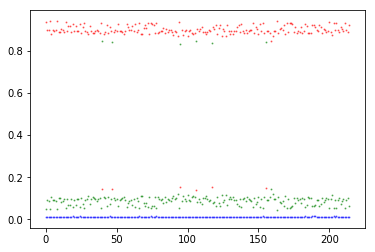

In [9]:
#print(my_model.g_gene)
#print(my_model.g_mirna)
plt.scatter(x=range(215), y=my_model.g_gene.detach().numpy(), s=1, c= 'red', alpha=0.5)
plt.scatter(x=range(215), y=my_model.g_methy.detach().numpy(), s=1, c= 'green', alpha=0.5)
plt.scatter(x=range(215), y=my_model.g_mirna.detach().numpy(), s=1, c= 'blue', alpha=0.5)

#print(my_model.A_tilda_gene)
#print(W_gene[range(215),range(215)])
#print(W_methy[range(215),range(215)])
#print(W_mirna[range(215),range(215)])

#print(my_model.A_tilda_gene)
#ordx = np.argsort(my_model.g_gene.detach().numpy())
#ordxx = ordx[0:150]
#ordxxx = ordx[150:215]
#plt.scatter(x=range(215), y=my_model.g_gene.detach().numpy(), s=1, c= 0.1*np.ones(215), alpha=0.5)
#plt.scatter(x=range(215), y=my_model.g_mirna.detach().numpy()[ordx], s=1, c= 0.1*np.ones(215), alpha=0.5)
#print(np.c_[my_model.g_gene.detach().numpy()[ordx],np.array(range(215))])
#print(truelabel[:,1][ordxx].mean())
#print(truelabel[:,1][ordxxx].mean())
#print()
#plt.scatter(x=range(215), y=my_model.g_gene.detach().numpy(), s=1, c= 0.1*np.ones(215), alpha=0.5)
#plt.scatter(x=range(215), y=my_model.g_methy.detach().numpy(), s=1, c= 0.4*np.ones(215), alpha=0.5)
#plt.scatter(x=range(215), y=my_model.g_mirna.detach().numpy(), s=1, c= 0.9*np.ones(215), alpha=0.5)
plt.show()


In [10]:

np.savetxt("/content/drive/My Drive/Data Fusion/results/W_v37.txt",my_model.A_tilda_hat.detach().numpy(),delimiter='\t')
np.savetxt("/content/drive/My Drive/Data Fusion/results/emb_v37.txt",my_model.embedding.detach().numpy(),delimiter='\t')
print(my_model.A_tilda_hat.detach().numpy())

[[8.78562927e-01 1.09875036e-05 7.14641237e-06 7.67550955e-06
  7.27393581e-06 4.85517103e-06 2.61853506e-06 5.13945542e-06
  5.74185924e-06 6.02037744e-06 8.52410540e-06 8.41111432e-06
  7.30525653e-06 5.35377103e-06 6.19037382e-06 6.74798594e-06
  1.21307830e-05 9.71934969e-06 8.21383037e-06 8.30045155e-06
  6.95990866e-06 4.72465354e-06 4.21553432e-06 3.15972557e-06
  2.94656411e-06 3.59365526e-06 3.78259415e-06 3.26586178e-06
  5.46181536e-06 4.23837673e-06 4.00326326e-06 3.83349425e-06
  2.96818371e-06 5.57754356e-06 4.25771350e-06 3.50071195e-06
  4.04034699e-06 3.27103885e-06 4.68959252e-06 4.79616301e-06
  6.54848463e-06 4.35714082e-06 4.69499219e-06 3.04352238e-06
  7.43393139e-06 5.19805371e-06 4.32268416e-06 6.40227472e-06
  6.62861976e-06 6.54475889e-06 3.48328945e-06 6.59485841e-06
  9.66249445e-06 5.45523289e-06 6.35055767e-06 6.03651142e-06
  5.37704000e-06 2.85912961e-06 2.65105996e-06 3.81904920e-06
  4.07150901e-06 4.00873432e-06 2.93148014e-06 3.16390765e-06
  6.3793

In [0]:
#my_model.forward(train_features_tensor)
#print((torch.abs(my_model.x_prim-train_features_tensor)).sum(1).mean(0))
print(my_model.layer_1.shape)
print(my_model.layer_2.shape)
print(my_model.layer_2[0:7,0:7])
print(torch.abs(my_model.x_prim-train_features_tensor).sum(1).mean(0))

torch.Size([215, 70])
torch.Size([215, 215])
tensor([[9.9999e-01, 1.1434e-10, 5.1351e-09, 3.0215e-10, 2.4378e-10, 6.0461e-09,
         3.3941e-10],
        [1.2205e-09, 1.0000e+00, 6.0084e-09, 4.8804e-10, 9.1650e-09, 5.1207e-08,
         6.1661e-11],
        [1.4392e-08, 2.7744e-09, 9.9999e-01, 6.2093e-10, 2.7217e-11, 7.4122e-09,
         3.0031e-07],
        [9.2908e-10, 2.2163e-10, 1.2287e-09, 9.9999e-01, 1.0383e-09, 5.0077e-08,
         6.1284e-09],
        [1.1780e-09, 2.3796e-08, 1.1304e-10, 1.3801e-09, 9.9999e-01, 3.1259e-08,
         3.4608e-11],
        [7.8229e-08, 3.5589e-07, 3.4932e-08, 8.1901e-08, 5.3511e-08, 9.9999e-01,
         2.6378e-10],
        [2.6648e-10, 3.8454e-12, 2.6408e-07, 1.9389e-09, 3.5037e-12, 8.5426e-11,
         1.0000e+00]], grad_fn=<SliceBackward>)
tensor(1.8116e-05, grad_fn=<MeanBackward2>)


In [0]:
my_model.forward(train_features_tensor)
emb = my_model.embedding.detach().numpy()
np.savetxt("/content/drive/My Drive/Data Fusion/results/emb_v21.txt",emb,delimiter='\t')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
emb = np.loadtxt("/content/drive/My Drive/Data Fusion/results/emb_v11.txt",delimiter='\t')

[1, 1, 1, 1, 1]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0.046443432569503784 0.012687854766845703 0.108401984375


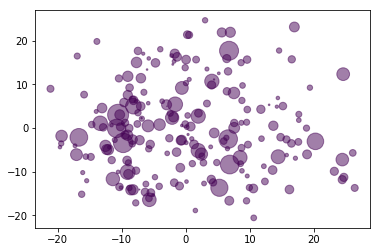

In [0]:
####PCA on embedding
my_model.forward(train_features_tensor)
emb = my_model.embedding.detach().numpy()
circle_areas = (truelabel[:,1].astype(float)/8)
X_embedded = PCA(n_components=2).fit_transform(emb)
plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1], s=circle_areas, c= 1*np.ones(215), alpha=0.5)
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0.0467371791601181 0.012687854766845703 0.108401984375


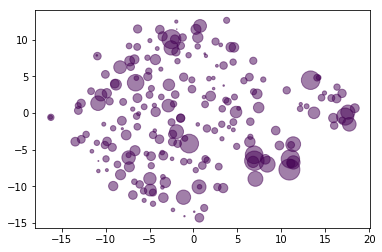

In [0]:
### TSNE on embedding
my_model.forward(train_features_tensor)
emb = my_model.embedding.detach().numpy()
circle_areas = (truelabel[:,1].astype(float)/8)
X_embedded = TSNE(n_components=2).fit_transform(emb)
plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1], s=circle_areas, c= 1*np.ones(215), alpha=0.5)
plt.show()

In [0]:
from sklearn.cluster import KMeans
X = emb
n_clusters=3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

for i in range(n_clusters):
    indx = np.argwhere(kmeans.labels_==i).reshape(-1)
    print(truelabel[indx][:,1].mean())



626.8765432098766
536.3030303030303
573.3168316831683


In [0]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
emb = np.loadtxt("/content/drive/My Drive/Data Fusion/results/emb_v11.txt",delimiter='\t')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
aaaa= torch.Tensor(np.array([[0,0,0],[4,5,0],[3,0,0]]))
print(torch.nonzero(aaaa))

tensor([[1, 0],
        [1, 1],
        [2, 0]])


In [0]:
print(str(tuple(my_model.A_tilda_gene.shape)))

(215, 215)
